# LCLUC XGBoost

In [1]:
# Import packages
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rioxr
import xarray as xr
import rasterstats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from pathlib import Path
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split,RandomizedSearchCV, cross_val_score, KFold
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from scipy.stats import uniform, randint
from sklearn.utils.class_weight import compute_class_weight


pd.set_option('display.max_columns', None)


In [2]:
# Read in data
wrk_dir = Path.cwd().parent # go up a directory with parent
data_path = os.path.join(wrk_dir, 'data')

# Labels
all_label_data = pd.read_parquet(os.path.join(data_path, 'all_label_data.parquet'))

# Rasters - open as Dataset first
rasters_ds = xr.open_dataset(os.path.join(data_path, 'rasters_stack.nc'))

# Check what variables are in the dataset
print("Variables in dataset:", list(rasters_ds.data_vars))
# We want the second item in this list

Variables in dataset: ['spatial_ref', '__xarray_dataarray_variable__']


In [3]:
# Extract the main data variable
rasters = rasters_ds['__xarray_dataarray_variable__']
# rasters = rasters_ds[list(rasters_ds.data_vars)[0]]

print(f"Loaded {len(rasters.band)} bands")
print(f"Bands: {rasters.band.values}")

Loaded 50 bands
Bands: ['coastal_areosol_L30' 'blue_L30' 'green_L30' 'red_L30' 'NIR_narrow_L30'
 'SWIR1_L30' 'SWIR2_L30' 'cirrus_L30' 'TIR1_L30' 'TIR2_L30'
 'coastal_areosol_S30' 'blue_S30' 'green_S30' 'red_S30' 'red_edge_1_S30'
 'red_edge_2_S30' 'red_edge_3_S30' 'NIR_broad_S30' 'NIR_narrow_S30'
 'SWIR1_S30' 'SWIR2_S30' 'water_vapor_S30' 'cirrus_S30' 'blue_evi_l30'
 'blue_evi_s30' 'VV' 'VH' 'VV_VH' 'dem_band_0' 'dem_band_1' 'dem_band_2'
 'dem_band_3' 'dem_band_4' 'dem_band_5' 'GLCM_mean_red'
 'GLCM_variance_red' 'GLCM_homogeneity_red' 'GLCM_contrast_red'
 'GLCM_dissimilarity_red' 'GLCM_entropy_red' 'GLCM_second_moment_red'
 'GLCM_correlation_red' 'GLCM_mean_nir' 'GLCM_variance_nir'
 'GLCM_homogeneity_nir' 'GLCM_contrast_nir' 'GLCM_dissimilarity_nir'
 'GLCM_entropy_nir' 'GLCM_second_moment_nir' 'GLCM_correlation_nir']


In [4]:
# Create data set with only forest and non-forest labels 
def subset_labels(df, classes):
    """
    Create dataset with specified classes, combining all others as 'nonforest'
    """
    # Create a copy to avoid modifying original
    subset = df.copy()
    
    # Replace class values: keep if in classes list, otherwise set to 'nonforest'
    subset['class'] = subset['class'].apply(
        lambda x: x if x in classes else 'nonforest'
    )
    
    # Convert class column to categorical
    subset['class'] = subset['class'].astype('category')
    
    return subset

forest = subset_labels(all_label_data, ['forest'])
forest_water_bare = subset_labels(all_label_data, ['forest', 'water', 'bare'])

In [5]:
print(f"{forest['class'].value_counts()}\n")
print(forest_water_bare['class'].value_counts())

class
nonforest    1030
forest        270
Name: count, dtype: int64

class
nonforest    670
bare         270
forest       270
water         90
Name: count, dtype: int64


For the forest/non-forest, definitely have a class imbalance that should be considered in the model design...

In [6]:
forest.isna().sum()

class                      0
coastal_areosol_L30       19
blue_L30                  19
green_L30                 19
red_L30                   19
NIR_narrow_L30            19
SWIR1_L30                 19
SWIR2_L30                 19
cirrus_L30                19
TIR1_L30                  19
TIR2_L30                  19
coastal_areosol_S30        0
blue_S30                   0
green_S30                  0
red_S30                    0
red_edge_1_S30             0
red_edge_2_S30             0
red_edge_3_S30             0
NIR_broad_S30              0
NIR_narrow_S30             0
SWIR1_S30                  0
SWIR2_S30                  0
water_vapor_S30            0
cirrus_S30                 0
blue_evi_l30              19
blue_evi_s30               0
VV                         0
VH                         0
VV_VH                      0
dem_band_0                 0
dem_band_1                 0
dem_band_2                 0
dem_band_3                 0
dem_band_4                 0
dem_band_5    

## Model Design

In [7]:
# Impute missing values
all_label_clean = all_label_data.drop(columns=['GLCM_correlation_nir', 'GLCM_contrast_red'])

# Separate features and target
X = all_label_clean.drop(columns=['class'])
y = all_label_clean['class']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale to avoid warnings when imputing
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Impute remaining NAs using KNN
imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(imputer.fit_transform(X_scaled), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_encoded, test_size=0.3, random_state=42)  # Ensures both train/test have same class ratios


In [8]:
print("Training set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    pct = 100 * count / len(y_train)
    print(f"Class {cls} ({le.classes_[cls]}): {count:3d} ({pct:4.1f}%)")

Training set class distribution:
Class 0 (agriculture): 172 (18.9%)
Class 1 (bare): 187 (20.5%)
Class 2 (built): 196 (21.5%)
Class 3 (forest): 175 (19.2%)
Class 4 (oil_palm): 105 (11.5%)
Class 5 (water):  75 ( 8.2%)


### Define objective function

In [13]:
# Set up kfold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=808)

# Define objective function to minimize
def objective(params):
    model = XGBClassifier(
        n_estimators=int(params["n_estimators"]),
        learning_rate=params["learning_rate"],
        max_depth=int(params["max_depth"]),
        min_child_weight=params["min_child_weight"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        gamma=params["gamma"],
        reg_alpha=params["reg_alpha"],
        reg_lambda=params["reg_lambda"],
        # scale_pos_weight=params["scale_pos_weight"],  # Handle class imbalance
        random_state=808,
        n_jobs=-1
    )
    
    # Perform cross-validation with F1 score 
    scores = cross_val_score(
        model, 
        X_imputed,
        y_encoded, 
        cv=kf, 
        scoring='f1_weighted',  # Best for multi-class/imbalanced
        n_jobs=-1,
    )

    # Average F1 across folds (negate because hyperopt minimizes)
    f1 = np.mean(scores)

    return {'loss': -f1, 'status': STATUS_OK}

### Create Domain Space

In [11]:
# Define hyperparameter space
space = {
    'n_estimators': hp.randint('n_estimators', 200, 1000),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.randint('max_depth', 3, 10),
    'min_child_weight': hp.randint('min_child_weight', 1, 10),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.5, 1.5),
    # 'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10)
}

### Run Optimization Algorithm

In [14]:
# Run hyperopt
trials = Trials()
best_params = fmin(
    fn=objective, 
    space=space,      
    algo=tpe.suggest, 
    max_evals=100, # Can adjust this, originally set to 200
    trials=trials,       
    rstate=np.random.default_rng(808)  
)

print("Best parameters found:")
print(best_params)

100%|██████████| 100/100 [00:56<00:00,  1.77trial/s, best loss: -0.9591105583024099]
Best parameters found:
{'colsample_bytree': 0.968758507799884, 'gamma': 0.0029234119427729477, 'learning_rate': 0.0673453895107203, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 250, 'reg_alpha': 0.017880446312289466, 'reg_lambda': 0.7778453733189732, 'subsample': 0.7771184380210601}


### Train Model on Best Parameters

In [15]:
# Convert int hyperparameters to fix type error
best_params["n_estimators"] = int(best_params["n_estimators"])
best_params["max_depth"] = int(best_params["max_depth"])

# Initialize best hyperopt model
xgb_hyper = XGBClassifier(**best_params, random_state=808)

# Fit model
xgb_hyper.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluate
y_pred = xgb_hyper.predict(X_test)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}\n")
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        88
           1       0.87      0.92      0.89        83
           2       0.89      0.89      0.89        64
           3       1.00      0.95      0.97        95
           4       0.90      1.00      0.95        45
           5       1.00      1.00      1.00        15

    accuracy                           0.93       390
   macro avg       0.94      0.95      0.94       390
weighted avg       0.94      0.93      0.93       390


Confusion matrix:
[[81  7  0  0  0  0]
 [ 0 76  7  0  0  0]
 [ 3  4 57  0  0  0]
 [ 0  0  0 90  5  0]
 [ 0  0  0  0 45  0]
 [ 0  0  0  0  0 15]]

Accuracy score: 0.9333


In [16]:
# Feature Importance 
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_hyper.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

                 feature  importance
20             SWIR2_S30    0.137327
0    coastal_areosol_L30    0.112298
24          blue_evi_s30    0.087671
27                 VV_VH    0.070379
5              SWIR1_L30    0.068819
11              blue_S30    0.067040
10   coastal_areosol_S30    0.057368
14        red_edge_1_S30    0.052662
17         NIR_broad_S30    0.038797
25                    VV    0.037456
13               red_S30    0.035978
21       water_vapor_S30    0.035365
26                    VH    0.029786
16        red_edge_3_S30    0.017460
6              SWIR2_L30    0.013839
1               blue_L30    0.013633
15        red_edge_2_S30    0.013541
40  GLCM_correlation_red    0.011281
22            cirrus_S30    0.011001
3                red_L30    0.009455


In [17]:
# Drop bands we removed from analysis
rasters_subset = rasters.drop_sel(band=['GLCM_correlation_nir', 'GLCM_contrast_red'])

# Stack rasters into numpy array
raster_stack = rasters_subset.values  # shape: (bands, y, x)
n_bands, height, width = raster_stack.shape

# Reshape to (n_pixels, n_bands)
raster_2d = raster_stack.reshape(n_bands, -1).T


In [18]:
# Convert to DataFrame with proper column names
raster_df = pd.DataFrame(raster_2d, columns=rasters_subset.band.values)

# Apply same scaling transformation used during training
raster_scaled = pd.DataFrame(
    scaler.transform(raster_df),
    columns=raster_df.columns
)

# Impute NAs in raster data
raster_imputed = pd.DataFrame(
    imputer.transform(raster_scaled), 
    columns=raster_scaled.columns
)

In [19]:
# Chunk for efficiency
chunk_size = 100000
predictions_encoded = []

for i in range(0, len(raster_imputed), chunk_size):
    chunk = raster_imputed.iloc[i:i+chunk_size]
    pred_chunk = xgb_hyper.predict(chunk)
    predictions_encoded.extend(pred_chunk)

predictions_encoded = np.array(predictions_encoded)

# Decode predictions back to class names
predictions = le.inverse_transform(predictions_encoded)

# Map to numeric values for raster output
label_map = {'forest': 1, 'water': 2, 'bare': 3, 'agriculture': 4, 'built': 5, 'oil_palm': 6, 'nonforest': 0}
predictions_numeric = np.array([label_map.get(p, 0) for p in predictions])

# Reshape back to raster dimensions
prediction_raster = predictions_numeric.reshape(height, width)

# Handle NaN values - set to a nodata value
prediction_raster = prediction_raster.astype(float)
nodata_value = -9999
prediction_raster = np.where(np.isnan(prediction_raster), nodata_value, prediction_raster)

In [24]:
# Prep for output
output = rasters.isel(band=0).copy()  # Template from first band
output.values = prediction_raster

# Clear all attributes and set only what's needed
output.attrs = {}
output.attrs['long_name'] = 'forest_prediction'

# Set nodata value
# output.rio.write_nodata(nodata_value, inplace=True)

# Write out tif
# output.rio.to_raster(os.path.join(data_path, 'output', 'forest_prediction.tif'))

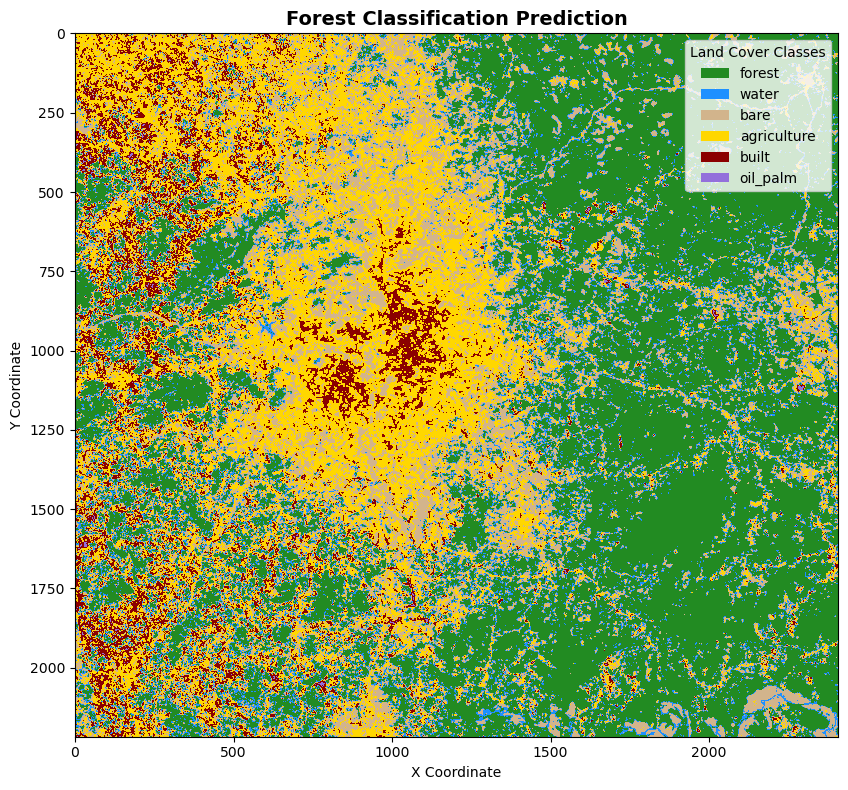

In [20]:
# Define label map
label_map = {'forest': 1, 'water': 2, 'bare': 3, 'agriculture': 4, 'built': 5, 'oil_palm': 6, 'nonforest': 0}

# Create reverse mapping (value to label)
value_to_label = {v: k for k, v in label_map.items()}
value_to_label[-9999] = 'nodata'  # Add nodata category

# Define colors for each class
colors = {
    0: '#d3d3d3',      # nonforest - light gray
    1: '#228B22',      # forest - forest green
    2: '#1E90FF',      # water - dodger blue
    3: '#D2B48C',      # bare - tan
    4: '#FFD700',      # agriculture - gold
    5: '#8B0000',      # built - dark red
    6: '#9370DB',      # oil_palm - medium purple
    -9999: '#000000'   # nodata - black
}

# Get unique values in prediction raster
unique_values = np.unique(prediction_raster)
unique_values = unique_values[unique_values != -9999]  # Exclude nodata from main categories

# Create colormap
cmap = mcolors.ListedColormap([colors[val] for val in sorted(unique_values)])
boundaries = sorted(unique_values) + [max(unique_values) + 1]
norm = mcolors.BoundaryNorm(boundaries, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(prediction_raster, cmap=cmap, norm=norm)

# Create legend
legend_labels = [value_to_label[val] for val in sorted(unique_values)]
legend_colors = [colors[val] for val in sorted(unique_values)]

# Create custom legend patches
legend_elements = [Patch(facecolor=legend_colors[i], label=legend_labels[i]) 
                   for i in range(len(legend_labels))]

ax.legend(handles=legend_elements, loc='upper right', title='Land Cover Classes')
ax.set_title('Forest Classification Prediction', fontsize=14, fontweight='bold')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

plt.tight_layout()
plt.show()

### Step 2: Determine best number of trees using early stopping
As a guard against overfitting while maximizing performance, we use **early stopping**. We start with a large number of trees and allow XGBoost to determine the optimal number by stopping training when the validation error no longer improves.

The choice of hyperparameter starting values is important in this process. We begin with:
- `n_estimators=1000` to ensure the model has enough capacity to learn meaningful patterns.
- `learning_rate=0.1` as a reasonable default that balances learning speed and performance.
- `eval_metric="logloss"` as the metric of performance to optimize.
- `early_stopping_rounds=50` to halt training if no improvement is seen for 50 rounds, preventing unnecessary computations.
- `random_state = 808`

We then `fit()` our specified baseline model, passing in the training sets as usual and specifying validation sets values for the `eval_set` parameter.

Finally, get and print the best number of trees from the fitted baseline model.


In [ ]:
# Initialize XGB model
xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1, 
    early_stopping_rounds=50, 
    eval_metric="logloss", 
    random_state=808)

# Fit model
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

In [ ]:
# Feature Importance 
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

                feature  importance
10  coastal_areosol_S30    0.167140
24         blue_evi_s30    0.126484
11             blue_S30    0.098665
5             SWIR1_L30    0.067222
2             green_L30    0.055974
1              blue_L30    0.044298
14       red_edge_1_S30    0.044013
6             SWIR2_L30    0.036907
20            SWIR2_S30    0.032166
12            green_S30    0.031920


In [ ]:
# See what the best parameter selections were
grid_search.best_params_

{'class_weight': 'balanced',
 'max_depth': 20,
 'min_samples_split': 5,
 'n_estimators': 100}

In [19]:
# Initiate model with best parameters
best_rf_model = RandomForestClassifier(
    **grid_search.best_params_,
    n_jobs=-1,
    random_state = 808
)

In [29]:
# Fit model
best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}\n")
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

      forest       0.99      0.98      0.98        81
   nonforest       0.99      1.00      1.00       309

    accuracy                           0.99       390
   macro avg       0.99      0.99      0.99       390
weighted avg       0.99      0.99      0.99       390


Confusion matrix:
[[ 79   2]
 [  1 308]]

Accuracy score: 0.9923


In [ ]:
rasters_subset = rasters.drop_sel(band=['GLCM_correlation_nir', 'GLCM_contrast_red'])


In [ ]:
# Stack rasters into numpy array
raster_stack = rasters_subset.values  # shape: (bands, y, x)
n_bands, height, width = raster_stack.shape

# Reshape to (n_pixels, n_bands)
raster_2d = raster_stack.reshape(n_bands, -1).T


In [ ]:
# Convert to DataFrame with proper column names
raster_df = pd.DataFrame(raster_2d, columns=rasters_subset.band.values)

# Apply same scaling transformation used during training
raster_scaled = pd.DataFrame(
    scaler.transform(raster_df),
    columns=raster_df.columns
)

# Impute NAs in raster data
raster_imputed = pd.DataFrame(
    imputer.transform(raster_scaled), 
    columns=raster_scaled.columns
)


In [ ]:
# Chunk for efficiency
chunk_size = 100000
predictions = []

for i in range(0, len(raster_imputed), chunk_size):
    chunk = raster_imputed.iloc[i:i+chunk_size]
    pred_chunk = best_rf_model.predict(chunk)
    predictions.extend(pred_chunk)

predictions = np.array(predictions)


In [ ]:
# Recode to Numeric
label_map = {'forest': 1, 'nonforest': 0}
predictions_numeric = np.array([label_map.get(p, -1) for p in predictions])

# Reshape back to raster dimensions
prediction_raster = predictions_numeric.reshape(height, width)

# Handle NaN values - set to a nodata value
prediction_raster = prediction_raster.astype(float)  # Keep as float to preserve NaN
nodata_value = -9999
prediction_raster = np.where(np.isnan(prediction_raster), nodata_value, prediction_raster)


In [ ]:
# Prep for output
output = rasters.isel(band=0).copy()  # Template from first band
output.values = prediction_raster

# Clear all attributes and set only what's needed
output.attrs = {}
output.attrs['long_name'] = 'forest_prediction'

# Set nodata value
# output.rio.write_nodata(nodata_value, inplace=True)

# Write out tif
output.rio.to_raster(os.path.join(data_path, 'output', 'forest_prediction.tif'))

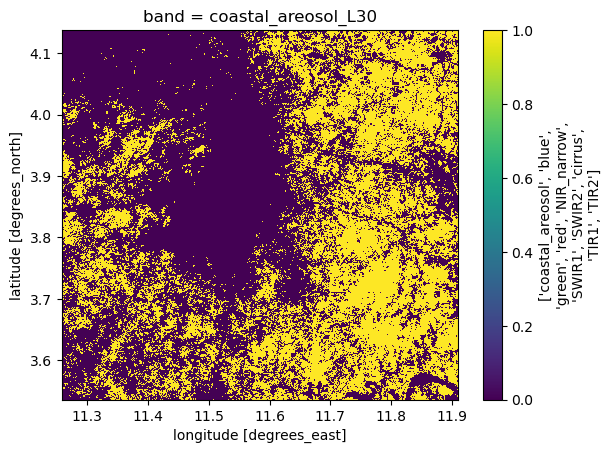

In [65]:
output.plot()